In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Optional but STRONGLY recommended
import gsw  # TEOS-10

plt.rcParams["figure.figsize"] = (6, 8)


In [14]:
FILE_PATH = r"C:\Users\ADITYA GUPTA\POSEIDON\data\argo_data_20251221_173238.csv"
df = pd.read_csv(FILE_PATH)

df.head()


,platform_number,latitude,longitude,time,pres,temp,psal
0,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,2.9,11.560,21.222
1,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,3.9,11.562,21.703
2,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,5.0,11.561,21.487
3,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,6.1,11.561,21.112
4,3902005,42.345547,34.792247,2024-01-03 21:04:00+00:00,6.9,11.560,21.318


In [21]:
def quality_control(df):
    df = df.copy()

    df = df[df["pres"] >= 0]
    df = df[df["temp"].between(-2, 40)]
    df = df[df["psal"].between(0, 42)]

    df = df.sort_values("pres")
    df = df.dropna()

    return df

df_qc = quality_control(df)


In [22]:
def bin_profile(df, step=10):
    df["pres_bin"] = (df["pres"] // step) * step
    return df.groupby("pres_bin").mean(numeric_only=True).reset_index()

df_bin = bin_profile(df_qc)


In [23]:
df_bin["temp_smooth"] = savgol_filter(
    df_bin["temp"], window_length=7, polyorder=2
)

df_bin["psal_smooth"] = savgol_filter(
    df_bin["psal"], window_length=7, polyorder=2
)


In [24]:
lat = df_bin["latitude"].iloc[0]
lon = df_bin["longitude"].iloc[0]

SA = gsw.SA_from_SP(
    df_bin["psal_smooth"],
    df_bin["pres_bin"],
    lon,
    lat
)

CT = gsw.CT_from_t(
    SA,
    df_bin["temp_smooth"],
    df_bin["pres_bin"]
)

sigma0 = gsw.sigma0(SA, CT)

df_bin["density_sigma0"] = sigma0


In [25]:
df_bin["dT_dz"] = np.gradient(
    df_bin["temp_smooth"],
    df_bin["pres_bin"]
)

thermocline_depth = df_bin.loc[
    df_bin["dT_dz"].abs().idxmax(),
    "pres_bin"
]

thermocline_depth


np.float64(60.0)

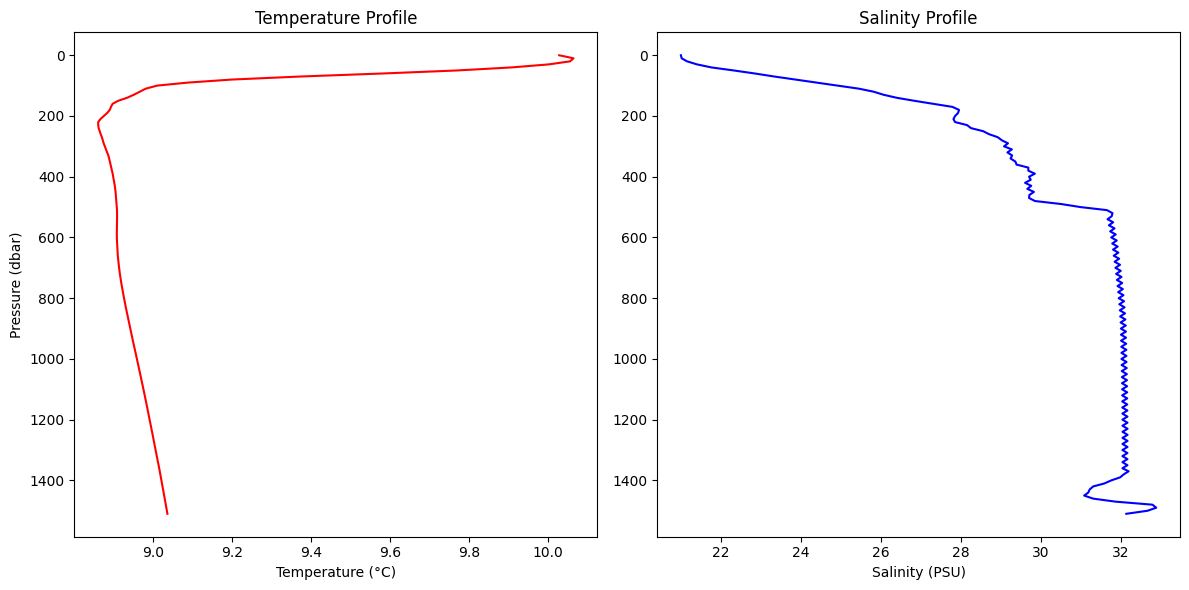

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Temperature profile
ax[0].plot(df_bin["temp_smooth"], df_bin["pres_bin"], "r")
ax[0].invert_yaxis()
ax[0].set_xlabel("Temperature (°C)")
ax[0].set_ylabel("Pressure (dbar)")
ax[0].set_title("Temperature Profile")

# Salinity profile
ax[1].plot(df_bin["psal_smooth"], df_bin["pres_bin"], "b")
ax[1].invert_yaxis()
ax[1].set_xlabel("Salinity (PSU)")
ax[1].set_title("Salinity Profile")

plt.tight_layout()
plt.show()
